In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is: ',device)

Device is:  cuda


## Set up Dataset

In [3]:
vocab_size = 10000
max_len = 200

In [4]:
(x_train,y_train) , (x_test,y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train,maxlen=max_len,padding='post')
x_test = pad_sequences(x_test,maxlen=max_len,padding='post')

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
train_dataset = TensorDataset(torch.tensor(x_train),torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(x_test),torch.tensor(y_test))

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

## Create RNN Model

In [6]:
class RNN(nn.Module):
    def __init__(self,vocab_size,hidden_dim,embedding_dim,output_dim):
        super(RNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.rnn = nn.RNN(embedding_dim,hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)


    def forward(self,x):
        embedded = self.embedding(x)
        output , hidden = self.rnn(embedded)
        return torch.sigmoid(self.fc(hidden.squeeze(0)))
    
model = RNN(vocab_size=vocab_size,embedding_dim=128,hidden_dim=128,output_dim=1).to(device)
print(model)


RNN(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [7]:
loss_func = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)

### Components of RNN
- input layer
    - takes sequential data as input at each time step
- hidden layer
    - maintains a 'memory' of past inputs through recurrent connections. The hidden state at time t(ht) is calculated
    - h = f(w.h + w.x+b)
        - wh: weight matrix for recurrent connections
        - wx: weight matrix for input connections
        - b: bias term
        - f: non linear activation function
- output layer
    - produces output y based on hidden state h
    - activation function (softmax for classification)

### Backpropagation through time (BPTT)
- What is BPTT
    - extension of backprogation to handle sequential data in RNN
    - calculate gradients for each time step and propagates them backwards through the sequence
- Steps
    - unroll the RNN across the sequence for a fixed number of time steps
    - compute the loss for each time step
    - backpropagate the errors across all time steps to update weights
- Challenges
    - vanishing gradient problem
        - gradient diminish exponentially as they are backpropagated through time
        - leads to difficulty in learning long-term dependencies
    - exploding gradient problem
        - gradient grow exponentially, causing numerical instability during trainin
- Solution
    - use gradient clipping to handle exploding gradient
    - use architectures like LSTM or GRU to mitigate vanishing gradient problem
- Limitations
    - short term memory -> due to vanishing gradient
    - sequential computation
    - sensitive initialisation -> need proper weight initialisation and LR



## Train RNN Model

In [8]:
def train_model(model, train_loader, loss_func, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        acc = 0
        for x_batch, y_batch in tqdm(train_loader):
            # Move data to the same device as model
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(x_batch).squeeze(1)
            loss = loss_func(predictions, y_batch.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            acc += ((predictions > 0.5) == y_batch).float().mean().item()

        losses.append(epoch_loss/len(train_loader))
        print(f'Epoch {epoch+1}, loss: {epoch_loss/len(train_loader):.4f}, accuracy: {acc/len(train_loader):.4f}')

    return losses
        
losses = train_model(model,train_loader,loss_func,optimizer)

100%|██████████| 782/782 [00:03<00:00, 215.15it/s]


Epoch 1, loss: 0.6871, accuracy: 0.5303


100%|██████████| 782/782 [00:02<00:00, 331.36it/s]


Epoch 2, loss: 0.6509, accuracy: 0.5825


100%|██████████| 782/782 [00:02<00:00, 321.01it/s]


Epoch 3, loss: 0.6247, accuracy: 0.5998


100%|██████████| 782/782 [00:02<00:00, 363.76it/s]


Epoch 4, loss: 0.5989, accuracy: 0.6209


100%|██████████| 782/782 [00:02<00:00, 368.20it/s]


Epoch 5, loss: 0.5744, accuracy: 0.6388


100%|██████████| 782/782 [00:02<00:00, 366.32it/s]


Epoch 6, loss: 0.5842, accuracy: 0.6304


100%|██████████| 782/782 [00:02<00:00, 363.34it/s]


Epoch 7, loss: 0.5329, accuracy: 0.6555


100%|██████████| 782/782 [00:02<00:00, 305.51it/s]


Epoch 8, loss: 0.5169, accuracy: 0.6664


100%|██████████| 782/782 [00:02<00:00, 366.38it/s]


Epoch 9, loss: 0.4885, accuracy: 0.6823


100%|██████████| 782/782 [00:02<00:00, 366.68it/s]

Epoch 10, loss: 0.4632, accuracy: 0.6885


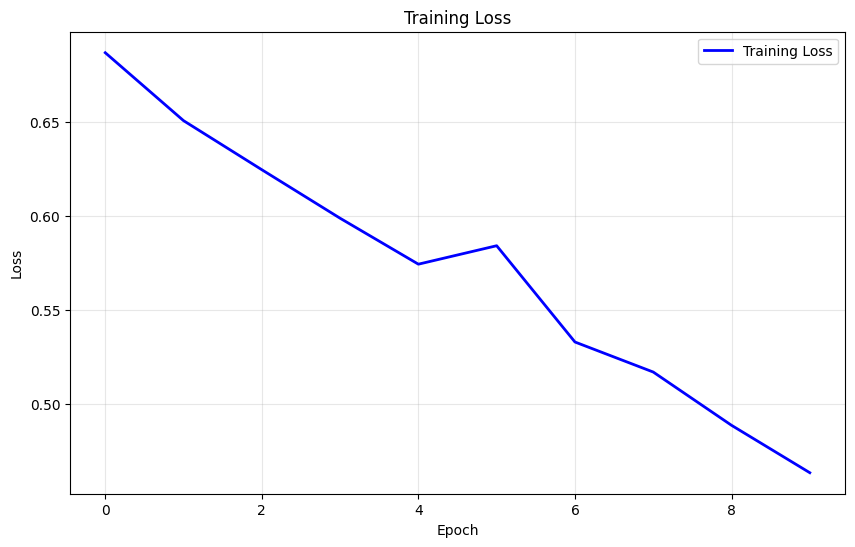

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(losses, 'b-', linewidth=2, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Test RNN Model

In [10]:
def evaluate_model(model, x_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(x_batch).squeeze(1)
            batch_loss = loss_func(predictions, y_batch.float())
            
            batch_correct = ((predictions > 0.5) == y_batch).float().sum().item()
            
            total_loss += batch_loss.item() * x_batch.size(0)
            total_correct += batch_correct
            total_samples += x_batch.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

evaluate_model(model, x_test, y_test, batch_size=32)  

Test Loss: 0.7735, Test Accuracy: 0.5833
